# Problem Statement
## Credit Card Lead Prediction
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

# Data Description 

ID: Unique Identifier for a row

Gender: Gender of the Customer

Age: Age of the Customer (in Years)

Region_Code: Code of the Region for the customers

Occupation: Occupation Type for the customer

Channel_Code: Acquisition Channel Code for the Customer  (Encoded)

Vintage: Vintage for the Customer (In Months)

Credit_Product: If the Customer has any active credit product (Home loan,Personal loan,Credit Card etc.)

Avg_Account_Balance: Average Account Balance for the Customer in last 12 Months

Is_Active: If the Customer is Active in last 3 Months

Is_Lead(Target): if the customer is intrested in the credit card

0 : Customer is not interested

1 : Customer is interested

# Expected Outcome
the predicted probabilities of Response(Is_Lead) for the customers

In [1]:
# General
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
from functools import partial
from scipy.optimize import fmin as scip_fmin
from tqdm import tqdm
import statistics
import tempfile

In [2]:
#!pip install delayed

In [3]:
# Machine Learning
# Utils
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split, KFold
from sklearn import preprocessing
import category_encoders as ce
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import impute
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import base

In [4]:
#Feature Selection
from sklearn.feature_selection import chi2, f_classif, f_regression, mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile, VarianceThreshold
from sklearn.decomposition import TruncatedSVD

In [5]:
#!pip install imblearn

In [6]:
#!pip install category_encoders

In [7]:
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from PIL import Image

In [9]:
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [10]:
#!pip install lightgbm

In [11]:
#Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [12]:
#!pip install xgboost

In [13]:
#!pip install catboost

In [15]:
train = pd.read_csv('train_1.csv')
test = pd.read_csv('test_1.csv')

In [16]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [18]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


#### 1. Null Values
We can see that there are some Null values in some columns. Which is not good for data ingestion into any model, so let's see the Null situation upfront:-

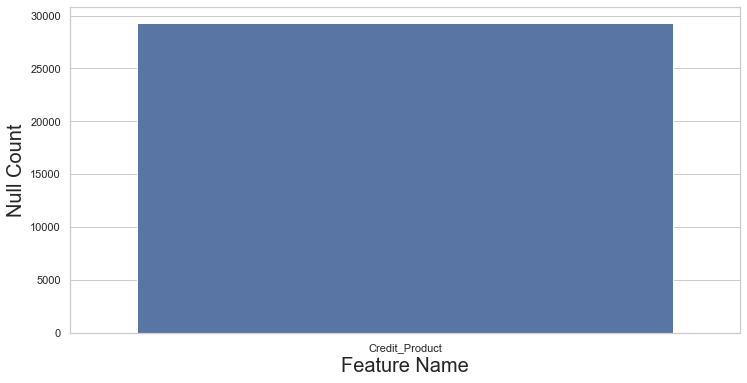

There are 1 features with missing values in the training data.
Columns containing nulls are: ['Credit_Product']


In [20]:
nulls_train = np.sum(train.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)

barplot_dim = (12, 6)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null Count", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_train), 'features with missing values in the training data.')
print(f'Columns containing nulls are: {list(nullcols_train.index)}')

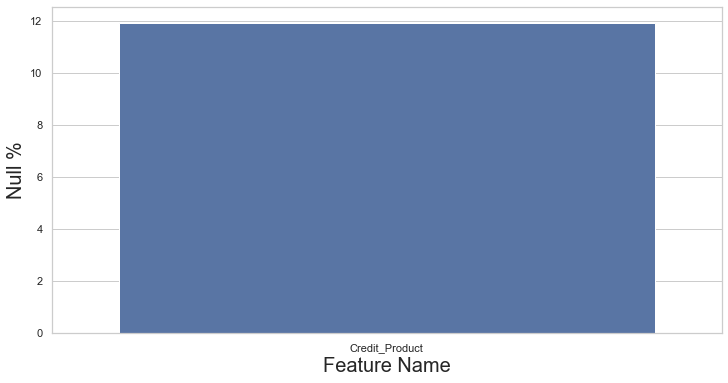

In [21]:
nulls_train = np.sum(train.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/train.shape[0])

barplot_dim = (12, 6)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

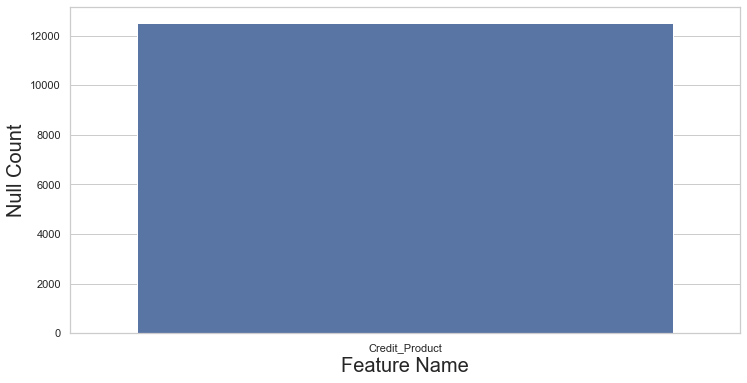

There are 1 features with missing values in the test data.
Columns containing nulls are: ['Credit_Product']


In [22]:
nulls_train = np.sum(test.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)

barplot_dim = (12, 6)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null Count", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_train), 'features with missing values in the test data.')
print(f'Columns containing nulls are: {list(nullcols_train.index)}')

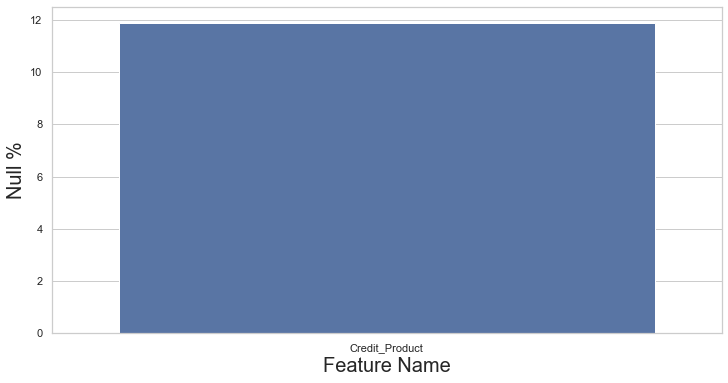

In [23]:
nulls_train = np.sum(test.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/test.shape[0])

barplot_dim = (12, 6)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

    So, we replace missing value with the mode because it's a categorical feature 
    

In [24]:
train.Credit_Product.fillna('No',inplace=True)
test.Credit_Product.fillna('No',inplace=True)

In [25]:
np.sum(train.isnull())

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [26]:
np.sum(test.isnull())

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
dtype: int64

# 2. Class Imbalance

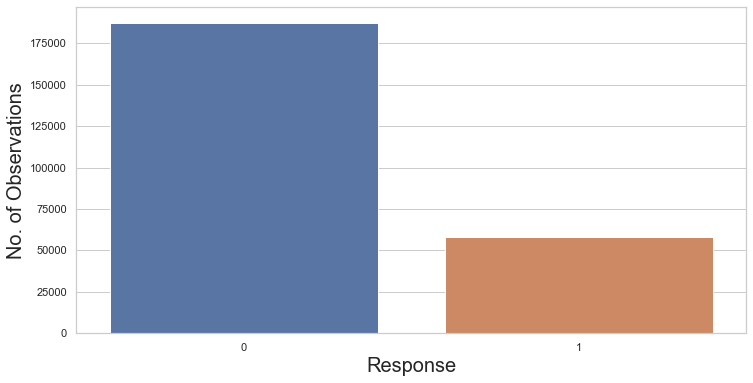

In [27]:
ax = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")
sns.countplot(x='Is_Lead', data=train);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Response", size=20);

Okay, so it is an imbalanced set. We have to keep that in mind while modelling and choosing hyper-parameters later.

# 3. Feature Value Counts
Another important thing to keep in mind during modelling

In [28]:
train.nunique()

ID                     245725
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    135292
Is_Active                   2
Is_Lead                     2
dtype: int64

#### since, Avg_Account_Balance has high number of unique values, we study how it varies our target variable.  

### we use catplot because it helps in studying the variation in terms of two categorical feature and one numerical feature.

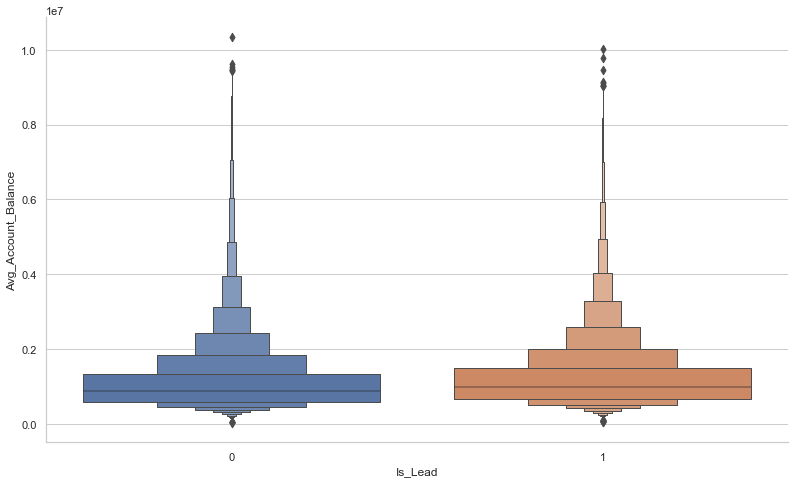

In [30]:
g = sns.catplot(x='Is_Lead', y='Avg_Account_Balance', kind='boxen', data=train);
g.fig.set_size_inches(12,7)

The distribution of Avg_Account_Balance of customers is sort of similar between a lead and no-lead customer.But there might be a variation if we consider Channel_Code of customer.

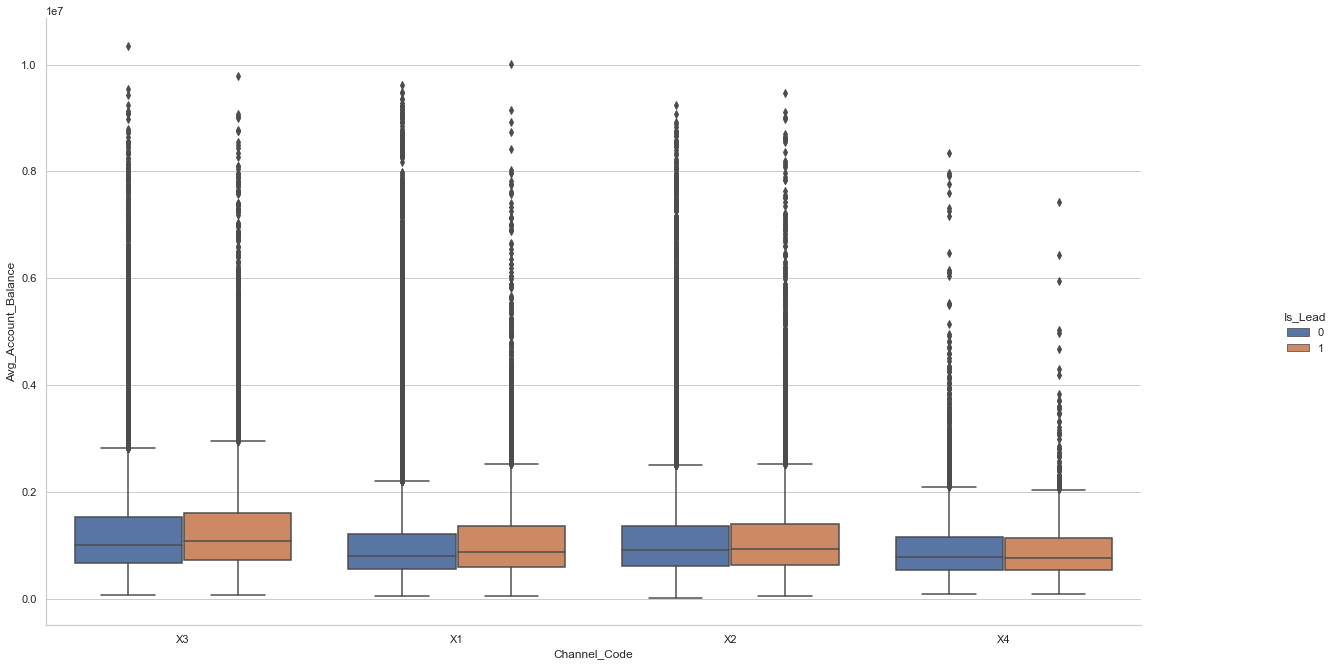

In [31]:
g = sns.catplot(x='Channel_Code', y='Avg_Account_Balance', hue='Is_Lead', kind='box', data=train);
g.fig.set_size_inches(20,10)

Also, Occupation type can have significant impact on someone's avrage account balance so variation related to that is also needed to be studied.

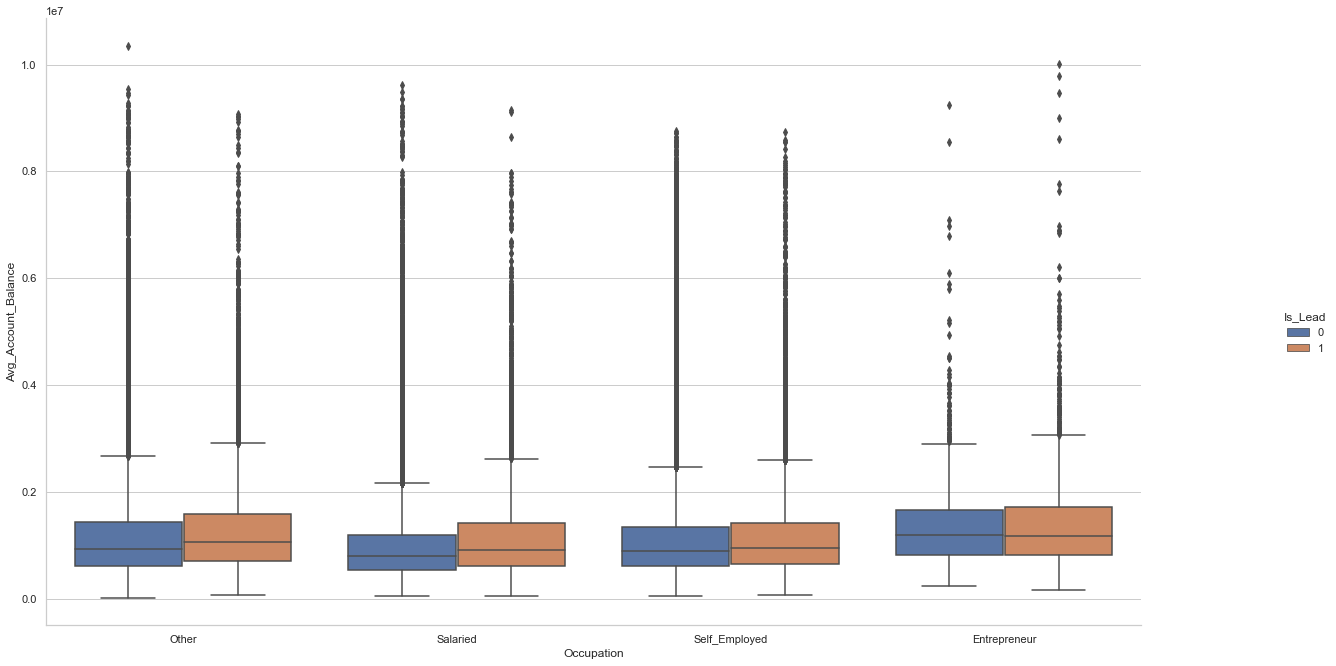

In [32]:
g = sns.catplot(x='Occupation', y='Avg_Account_Balance', hue='Is_Lead', kind='box', data=train);
g.fig.set_size_inches(20,10)

there might be some Gender bias, so, we study that as well

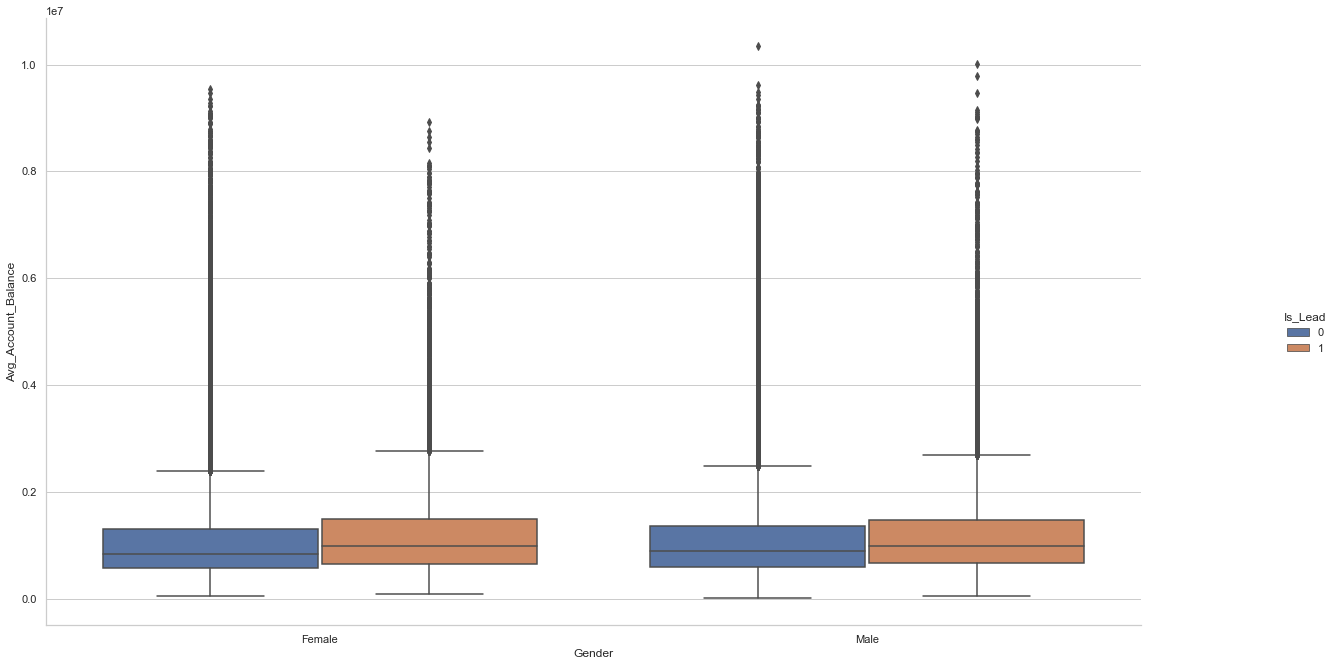

In [33]:
g = sns.catplot(x='Gender', y='Avg_Account_Balance', hue='Is_Lead', kind='box', data=train);
g.fig.set_size_inches(20,10)

Age can be another reason for lead to go cold as people older than 35 usaully already have credit cards or they don't want to have one.

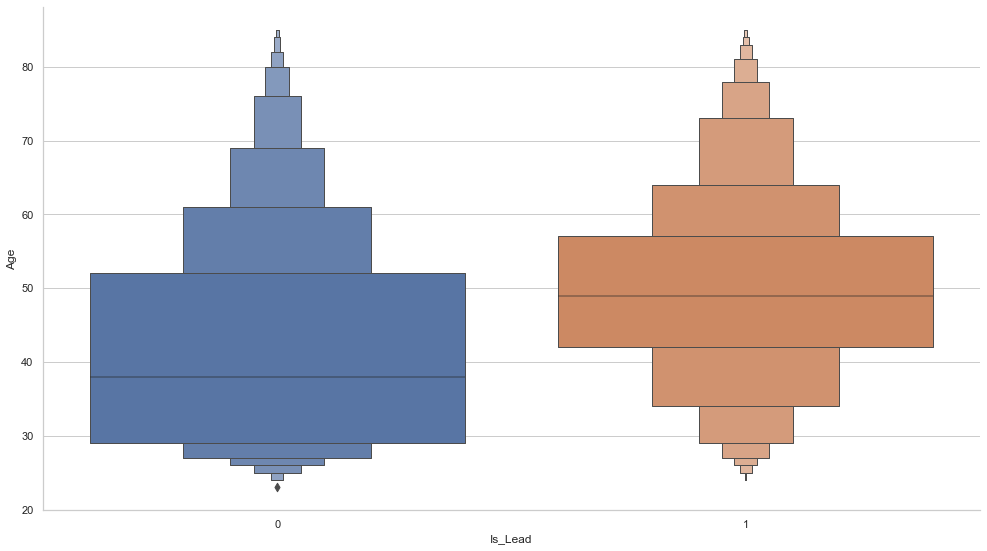

In [34]:
g = sns.catplot(x='Is_Lead', y='Age', kind='boxen', data=train);
g.fig.set_size_inches(15,8)

combination of age(people like to spend more in young age but they don't have enough money as a result they use credit cards) and occupation type(salaried people have regular income, so, mostly they like to spend according to that, but entrprenuers and self_employed people, sometimes requires a little help to pay there monthly bills) can give us useful insight for why a lead goes cold.

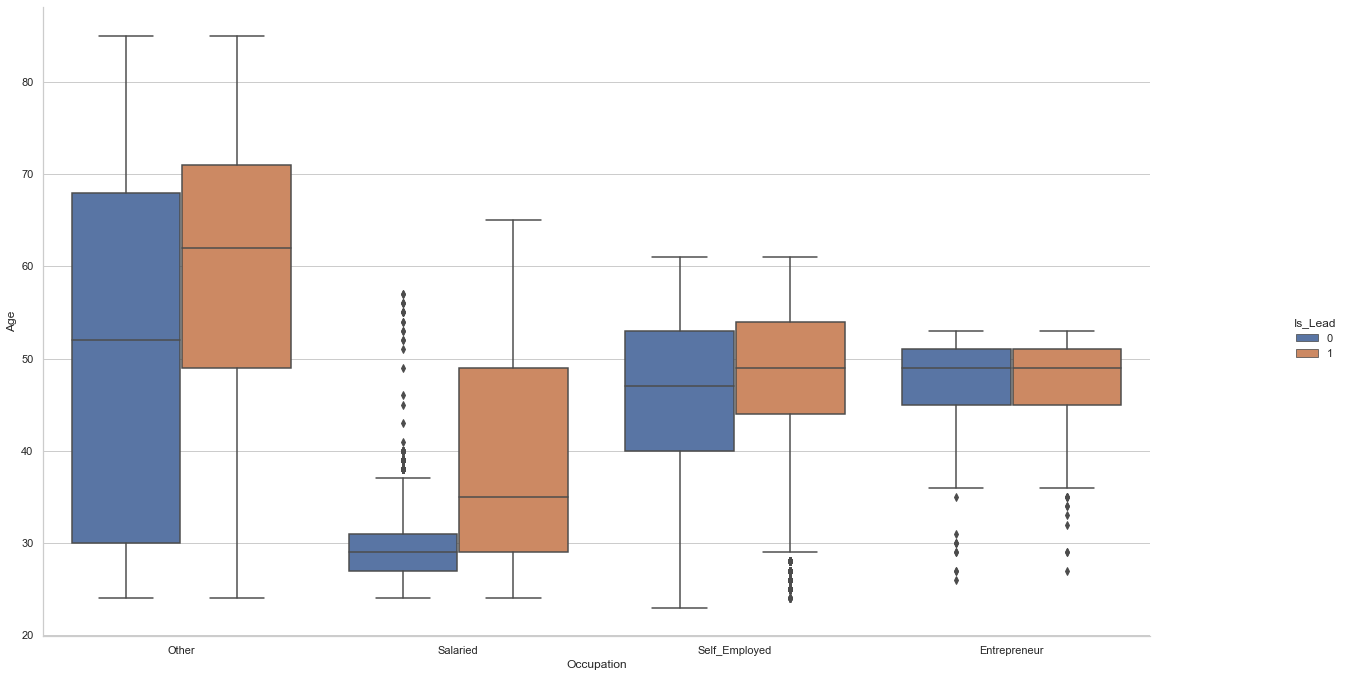

In [35]:
g = sns.catplot(x='Occupation', y='Age', hue='Is_Lead', kind='box', data=train);
g.fig.set_size_inches(20,10)

if a person already has an active credit product then they might not want to be in more debt than they already in but this mentallity changes if they already have a hugh bank balance. So, plot between Credit_Product, Average_Account_Balance and Is_lead can give us useful insights. 

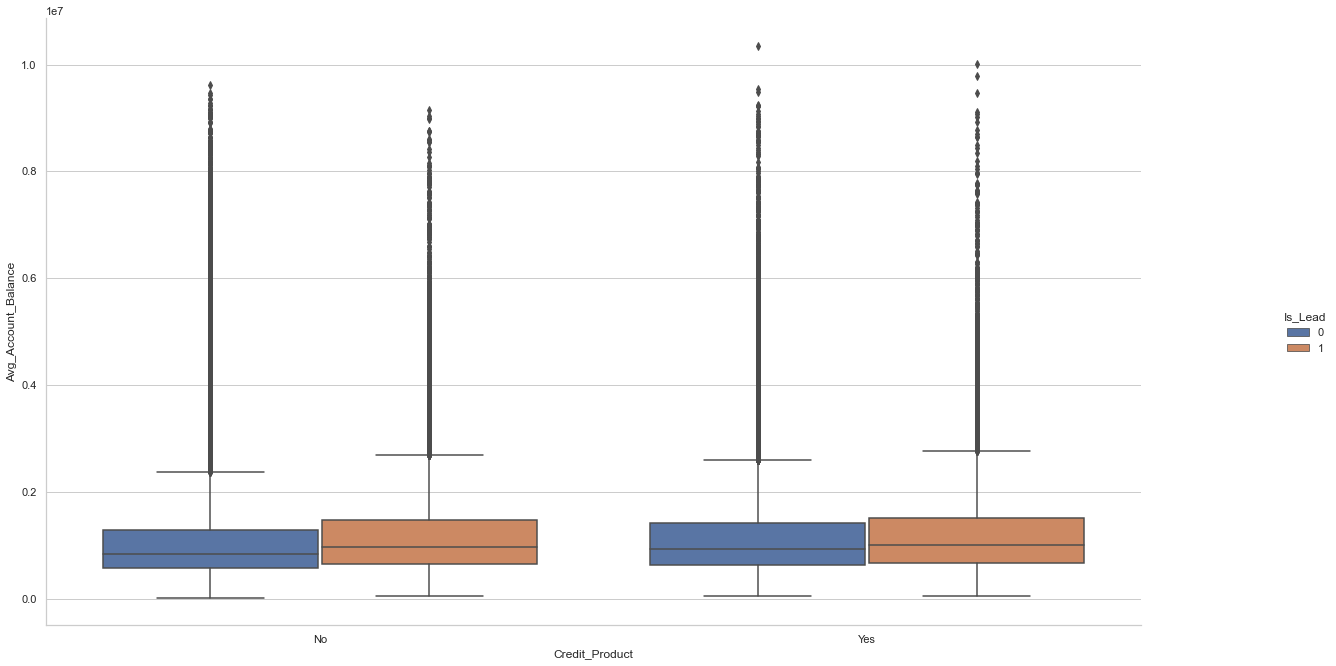

In [36]:
g = sns.catplot(x='Credit_Product', y='Avg_Account_Balance', hue='Is_Lead', kind='box', data=train);
g.fig.set_size_inches(20,10)

In [37]:
train.Gender.value_counts()

Male      134197
Female    111528
Name: Gender, dtype: int64

In [38]:
train.Is_Active.value_counts()

No     150290
Yes     95435
Name: Is_Active, dtype: int64

In [39]:
train.Occupation.value_counts()

Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64

In [40]:
train.Region_Code.nunique()

35

In [41]:
train.Region_Code.value_counts()

RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64

In [42]:
train.Channel_Code.nunique()

4

In [45]:
categorical_features = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']

In [46]:
target = ['Is_Lead']
not_features = ['ID', 'Is_Lead', 'kfold']
cols = list(train.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)
numerical_features = [feat for feat in features if feat not in categorical_features]

print(f'Categorical Features: {categorical_features}')
print(f'Numerical Features: {numerical_features}')

['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']
Categorical Features: ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
Numerical Features: ['Age', 'Vintage', 'Avg_Account_Balance']


In [ ]:
g = sns.pairplot(train[numerical_features + ['Is_Lead']], hue='Is_Lead')
g.fig.set_size_inches(10,8)

# k-fold split

In [ ]:
NUM_SPLITS = 5

train["kfold"] = -1
train = train.sample(frac=1).reset_index(drop=True)
y = train.Is_Lead.values
kf = StratifiedKFold(n_splits=NUM_SPLITS)
for f, (t_, v_) in enumerate(kf.split(X=train, y=y)):
    train.loc[v_, 'kfold'] = f
    
train.head()

# Feature engineering

In [ ]:
train['avg_acc_bal_Per_Age'] = np.log(train['Avg_Account_Balance'].astype(float)/train['Age'])
test['avg_acc_bal_Per_Age'] = np.log(test['Avg_Account_Balance'].astype(float)/test['Age'])

In [ ]:
train['Region_Channel'] = train["Channel_Code"].astype(str) + '_' + train["Region_Code"].astype(str)
test['Region_Channel'] = test["Channel_Code"].astype(str) + '_' + test["Region_Code"].astype(str)

In [ ]:
train['Age_Bin_10'] = pd.cut(train['Age'], bins=10, labels=False)
train['Age_Bin_50'] = pd.cut(train['Age'], bins=50, labels=False)
test['Age_Bin_10'] = pd.cut(test['Age'], bins=10, labels=False)
test['Age_Bin_50'] = pd.cut(test['Age'], bins=50, labels=False)

In [ ]:
train['Avg_Account_Balance_Bin_10'] = pd.cut(train['Avg_Account_Balance'].astype(float), bins=10, labels=False)
train['Avg_Account_Balance_Bin_50'] = pd.cut(train['Avg_Account_Balance'].astype(float), bins=50, labels=False)
test['Avg_Account_Balance_Bin_10'] = pd.cut(test['Avg_Account_Balance'].astype(float), bins=10, labels=False)
test['Avg_Account_Balance_Bin_50'] = pd.cut(test['Avg_Account_Balance'].astype(float), bins=50, labels=False)

In [ ]:
def make_whole_number(data):
    _data = str(int(data))
    _len_data = len(_data)
    _data = "".join(_data[0] + '0' * (_len_data-1))
    return int(_data)

In [ ]:
train.sample(5)

In [ ]:
train['avg_acc_bal_Per_Age_round'] = train['avg_acc_bal_Per_Age'].apply(make_whole_number)
test['avg_acc_bal_Per_Age_round'] = test['avg_acc_bal_Per_Age'].apply(make_whole_number)

In [ ]:
train['Vintage_in_years'] = train['Vintage'].astype(float)/12
test['Vintage_in_years'] = test['Vintage'].astype(float)/12

In [ ]:
train.info()

# Features Encoding
Irrespective of the column datatype, we can split the data based on their definition into categorical and Numeric Data types.

In [ ]:
target = ['Is_Lead']
not_features = ['ID', 'Is_Lead', 'kfold']
cols = list(train.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

In [ ]:
categorical_features = ['Gender', 'Region_Channel', 'Is_Active', 'Credit_Product', 'Channel_Code', 'Region_Code', 'Occupation', 'Age_Bin_10', 'Age_Bin_50', 'Avg_Account_Balance_Bin_10', 'Avg_Account_Balance_Bin_50', 'Vintage', 'Vintage_in_years']

In [ ]:
numerical_features = [feat for feat in features if feat not in categorical_features]

print(f'Categorical Features: {categorical_features}\n')
print(f'Numeric Features: {numerical_features}')

In [ ]:
train[categorical_features] = train[categorical_features].astype('str')
test[categorical_features] = test[categorical_features].astype('str')

In [ ]:
train[numerical_features] = train[numerical_features].astype('float64')
test[numerical_features] = test[numerical_features].astype('float64')

In [ ]:
train[target] = train[target].astype('float64')

In [ ]:
train.sample(5)

In [ ]:
nominal_cols = ['Gender', 'Region_Channel', 'Is_Active', 'Credit_Product', 'Channel_Code', 'Region_Code', 'Occupation']
ordinal_cols = ['Age_Bin_10', 'Age_Bin_50', 'Avg_Account_Balance_Bin_10', 'Avg_Account_Balance_Bin_50', 'Vintage', 'Vintage_in_years']

In [ ]:
lbl_enc = preprocessing.LabelEncoder()
full_data = pd.concat(
    [train[categorical_features], test[categorical_features]],
    axis=0
)

for col in (categorical_features):
    print(col)
    if train[col].dtype == 'object':
        lbl_enc.fit(full_data[col].values)
        train[col] = lbl_enc.transform(train[col])
        test[col] = lbl_enc.transform(test[col])

# Features Selection
Now let's only select the important features to overcome the curse of dimensionality.

In [ ]:
target = ['Is_Lead']
not_features = ['ID', 'Is_Lead', 'kfold']
cols = list(train.columns)
features = [feat for feat in cols if feat not in not_features]

In [ ]:
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring, return_cols=True):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from
        scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """
        self.n_features = n_features
        
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k=n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring],
                percentile=int(n_features * 100)
            )
        else:
            raise Exception("Invalid type of feature")
    
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)
    
    def return_cols(self, X):
        if isinstance(self.n_features, int):
            mask = SelectKBest.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
                    
        elif isinstance(self.n_features, float):
            mask = SelectPercentile.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
        else:
            raise Exception("Invalid type of feature")
        
        return selected_features

In [ ]:
ufs = UnivariateFeatureSelction(
    n_features=0.7,
    problem_type="classification",
    scoring="f_classif"
)

ufs.fit(train[features], train[target].values.ravel())
# X_transformed = ufs.transform(train_df[features])
selected_features = ufs.return_cols(train[features])

In [ ]:
selected_features

# find best models 

In [ ]:
def rate_model(clf, x, cv = StratifiedKFold(n_splits=NUM_SPLITS),
               fold=0, features=selected_features, target=target):
    '''
    Prints out various evaluation metrics for a classification task. Like:-
    1. Classification Accuracy
    2. ROC-AUC Score
    3. Precision
    4. Recall
    5. F1 Score
    6. Confusion matrix
    All score are calculated in base format. No averaging is performed.
    
    clf - Classification Model
    x - Input features
    cv - Cross Validation criteria
    fold - fold number for confusion matrix
    features - Feature column names
     target - Target column name
    '''
    
    scoring = {'acc' : 'accuracy', 'roc' : 'roc_auc', 'precision' : 'precision', 'recall' : 'recall', 'f1' : 'f1'}
    scores = cross_validate(clf, x[features], x[target].values.ravel(), scoring=scoring, cv=cv, return_train_score=False)
    roc = np.mean(scores['test_roc'])
    acc = np.mean(scores['test_acc'])
    prec = np.mean(scores['test_precision'])
    rec = np.mean(scores['test_recall'])
    f1 = np.mean(scores['test_f1'])
    print(f'ROC: {roc}')
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
    print(f'F-Score: {f1}')

In [ ]:
clf = LogisticRegression(C=1.0, max_iter=5000)
rate_model(clf, train, fold=3)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
rate_model(clf, train, fold=3)

In [ ]:
RANDOM_SEED = 42

In [ ]:
clf = RandomForestClassifier(n_estimators = 100,
                             random_state=RANDOM_SEED,
                             n_jobs=-1,
                             class_weight='balanced_subsample')
rate_model(clf, train, fold=3)

In [ ]:
NUM_BOOSTERS = 1000

clf = xgb.XGBClassifier(max_depth=7,
                        n_estimators=NUM_BOOSTERS,
                        colsample_bytree=0.8,
                        subsample=0.8,
                        nthread=-1,
                        learning_rate=0.1)
rate_model(clf, train, fold=3)

In [ ]:
NUM_BOOSTERS = 1000
METRIC = 'auc'
cat_cols = [i for i, col in enumerate(train[selected_features].columns) if col not in numerical_features]
EARLY_STOPPING = 100

clf = LGBMClassifier(metric=METRIC,
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
rate_model(clf, train, fold=3)

In [ ]:
NUM_BOOSTERS = 3000
EARLY_STOPPING = 100
METRIC = 'AUC'
cat_cols = [i for i, col in enumerate(train[selected_features].columns) if col not in numerical_features]

clf = CatBoostClassifier(verbose=0,
                         n_estimators=NUM_BOOSTERS,
                         eval_metric=METRIC,
                         random_seed=RANDOM_SEED,
                         cat_features=cat_cols)
rate_model(clf, train, fold=3)

In [ ]:
current_fold = 0
df_train = train[train.kfold != current_fold].reset_index(drop=True)
df_valid = train[train.kfold == current_fold].reset_index(drop=True)

In [ ]:
clf = CatBoostClassifier(verbose=0,
                         n_estimators=NUM_BOOSTERS,
                         eval_metric=METRIC,
                         random_seed=RANDOM_SEED,
                         cat_features=cat_cols,
                         early_stopping_rounds=EARLY_STOPPING)
clf.fit(df_train[selected_features], df_train.Is_Lead,
        eval_set=(df_valid[selected_features], df_valid.Is_Lead),
        plot=True, verbose=False);

ypred = clf.predict_proba(df_valid[selected_features])[:,1]


In [ ]:
roc_auc_score(df_valid.Is_Lead, ypred)

three best models are CatBoostClassifier, XGBClassifier and LGBMClassifier.

# find suitable weights

In [ ]:
current_fold = 4

df_train_4 = train[train.kfold != current_fold].reset_index(drop=True)
df_valid_4 = train[train.kfold == current_fold].reset_index(drop=True)

In [ ]:
lgb = LGBMClassifier(metric='auc',
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
cb = CatBoostClassifier(verbose=0,
                        n_estimators=NUM_BOOSTERS,
                        eval_metric='AUC',
                        random_seed=RANDOM_SEED,
                        cat_features=cat_cols)
xgbc = xgb.XGBClassifier()

In [ ]:
lgb.fit(df_train_4[selected_features], df_train_4[target].values.ravel())
cb.fit(df_train_4[selected_features], df_train_4[target].values.ravel())
xgbc.fit(df_train_4[selected_features], df_train_4[target].values.ravel())

In [ ]:
pred_lgb = lgb.predict_proba(df_valid_4[selected_features])[:, 1]
pred_cb = cb.predict_proba(df_valid_4[selected_features])[:, 1]
pred_xgbc = xgbc.predict_proba(df_valid_4[selected_features])[:, 1]
avg_pred = (pred_lgb + pred_cb + pred_xgbc) / 3

In [ ]:
fold4_preds = np.column_stack((
    pred_lgb,
    pred_cb,
    pred_xgbc,
    avg_pred
))

aucs_fold4 = []
for i in range(fold4_preds.shape[1]):
    auc = roc_auc_score(df_valid_4[target].values.ravel(), fold4_preds[:, i])
    aucs_fold4.append(auc)
    
print(f"Fold-2: LGB AUC = {aucs_fold4[0]}")
print(f"Fold-2: CB AUC = {aucs_fold4[1]}")
print(f"Fold-2: XGB AUC = {aucs_fold4[2]}")
print(f"Fold-2: Average Pred AUC = {aucs_fold4[3]}")

In [ ]:
current_fold = 1

df_train_1 = train[train.kfold != current_fold].reset_index(drop=True)
df_valid_1 = train[train.kfold == current_fold].reset_index(drop=True)

In [ ]:
lgb = LGBMClassifier(metric='auc',
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
cb = CatBoostClassifier(verbose=0,
                        n_estimators=NUM_BOOSTERS,
                        eval_metric='AUC',
                        random_seed=RANDOM_SEED,
                        cat_features=cat_cols)
xgbc = xgb.XGBClassifier()

In [ ]:
lgb.fit(df_train_1[selected_features], df_train_1[target].values.ravel())
cb.fit(df_train_1[selected_features], df_train_1[target].values.ravel())
xgbc.fit(df_train_1[selected_features], df_train_1[target].values.ravel())

In [ ]:
pred_lgb = lgb.predict_proba(df_valid_1[selected_features])[:, 1]
pred_cb = cb.predict_proba(df_valid_1[selected_features])[:, 1]
pred_xgbc = xgbc.predict_proba(df_valid_1[selected_features])[:, 1]
avg_pred = (pred_lgb + pred_cb + pred_xgbc) / 3

In [ ]:
fold1_preds = np.column_stack((
    pred_lgb,
    pred_cb,
    pred_xgbc,
    avg_pred
))

aucs_fold1 = []
for i in range(fold1_preds.shape[1]):
    auc = roc_auc_score(df_valid_1[target].values.ravel(), fold1_preds[:, i])
    aucs_fold1.append(auc)
    
print(f"Fold-2: LGB AUC = {aucs_fold1[0]}")
print(f"Fold-2: CB AUC = {aucs_fold1[1]}")
print(f"Fold-2: XGB AUC = {aucs_fold1[2]}")
print(f"Fold-2: Average Pred AUC = {aucs_fold1[3]}")

In [ ]:
class OptimizeAUC:
    def __init__(self):
        self.coef_ = 0
        
    def _auc(self, coef, X, y):
        x_coef = X * coef
        predictions = np.sum(x_coef, axis=1)
        auc_score = roc_auc_score(y, predictions)
        return -1.0 * auc_score
    
    def fit(self, X, y):
        loss_partial = partial(self._auc, X=X, y=y)
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)
        self.coef_ = scip_fmin(loss_partial, initial_coef, disp=True)
    def predict(self, X):
        x_coef = X * self.coef_
        predictions = np.sum(x_coef, axis=1)
        return predictions

In [ ]:
opt = OptimizeAUC()

opt.fit(fold1_preds[:, :-1], df_valid_1[target].values.ravel())
opt_preds_fold4 = opt.predict(fold4_preds[:, :-1])
auc = roc_auc_score(df_valid_4[target].values.ravel(), opt_preds_fold4)
print(f"Optimized AUC, Fold 2 = {auc}")
print(f"Coefficients = {opt.coef_}")

In [ ]:
def rate_ensemble_model(clfs, weights, X, fold=0, features=selected_features,
                        target=target):
    if len(clfs) != len(weights):
        raise Exception("Number of Classifiers and Weights unequal!")
    else:
        X_train = X[X.kfold != fold].reset_index(drop=True)
        X_valid = X[X.kfold == fold].reset_index(drop=True)
        
        preds = np.zeros(X_valid.shape[0])
        for i, clf in enumerate(clfs):
            clf.fit(X_train[features], X_train[target].values.ravel())
            preds += clf.predict_proba(X_valid[features])[:, 1] * weights[i]
        print(f'AUC Score: {roc_auc_score(X_valid[target].values.ravel(), preds)}')

In [ ]:
for i in range(NUM_SPLITS):
    rate_ensemble_model(clfs = [lgb, cb, xgbc],
                        weights = opt.coef_,
                        X = train_df, fold=i)

In [ ]:
def prepare_submission_one_model(clf, train_df=train_df, test_df=test_df,
                                 features=selected_features, target=target):
    clf.fit(train_df[features], train_df[target].values.ravel())
    preds = clf.predict_proba(test_df[features])[:, 1]
    output = pd.DataFrame({'ID': test_df['ID'],
                           'Is_Lead': preds})
    output.to_csv('submission1.csv', index=False)
    print('Prediction file saved. All the Best!')

In [ ]:
def prepare_submission_ensemble(clfs, weights= [], train_df=train, test_df=test,
                                features=selected_features, target=target):
    if len(clfs) != len(weights):
        raise Exception("Number of Classifiers and Weights unequal!")
    else:
        sum1 = np.array(weights).sum()
        preds = np.zeros(test_df.shape[0])
        for i, clf in enumerate(clfs):
            clf.fit(train_df[features], train_df[target].values.ravel())
            preds += clf.predict_proba(test_df[features])[:,1]*weights[i]/sum1
        output = pd.DataFrame({'ID': test_df['ID'],
                               'Is_Lead': preds})
        output.to_csv('submission.csv', index=False)
        print('Prediction file saved. All the Best!')

In [ ]:
lgb = LGBMClassifier(metric='auc',
                     seed=RANDOM_SEED,
                     n_estimators=NUM_BOOSTERS)
cb = CatBoostClassifier(verbose=0,
                        n_estimators=NUM_BOOSTERS,
                        eval_metric='AUC',
                        random_seed=RANDOM_SEED,
                        cat_features=cat_cols)
xgbc = xgb.XGBClassifier()



In [ ]:
prepare_submission_ensemble(clfs = [lgb, cb, xgbc],
                            weights = 
[-0.0153715,1.36772336,0.13537971])

In [ ]:
cb = CatBoostClassifier(verbose=0,
                         n_estimators=NUM_BOOSTERS,
                         eval_metric='AUC',
                         random_seed=RANDOM_SEED,
                         cat_features=cat_cols)
prepare_submission_one_model(clf)